<a href="https://colab.research.google.com/github/Shaunofthedead19/Default_Prediction/blob/main/Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Moving to Directory

In [1]:
%cd '/content/drive/MyDrive/EdgeRed/'

/content/drive/MyDrive/EdgeRed


In [2]:
!ls

Clients.csv		      logistic_regression_classifier.sav
Decision_Tree_classifier.sav  Payments.csv
EdgeRed_case_study.ipynb      XGBoost_classifier.sav


#Installing and Loading packages

In [3]:
!pip install 'https://github.com/pandas-profiling/pandas-profiling/archive/master.zip'

     / 38.5MB 678kB/s
     |████████████████████████████████| 10.1MB 24.4MB/s 
     |████████████████████████████████| 645kB 31.3MB/s 
     |████████████████████████████████| 112kB 46.9MB/s 
     |████████████████████████████████| 1.1MB 30.7MB/s 
     |████████████████████████████████| 3.1MB 33.2MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 296kB 44.3MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.0.0-py2.py3-none-any.whl size=248525 sha256=adae34460ac51ffd1d5f047f86e3781701cd3c56a0bde2c9d77dbc507e942626
  Stored in directory: /tmp/pip-ephem-wheel-cache-sb45qt3a/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=04e94620946273f2fb9e1cb4220e3adaaac8f6503141afbe58e0e2858b651fcd
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f940

In [3]:
from pandas_profiling import ProfileReport

In [4]:
import pandas as pd
import numpy as np

In [5]:
import calendar
import datetime as dt

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [7]:
!pip install xgboost

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from inspect import signature

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve

In [34]:
from statistics import mean

In [11]:
import pickle
from collections import Counter

#Loading Data

In [67]:
client_data = pd.read_csv('/content/drive/MyDrive/EdgeRed/Clients.csv')
print(client_data.shape)
client_data.head()

(1287, 3)


client_id                 entity_type  entity_year_established
0        786  Australian Private Company                     2002
1        230  Australian Private Company                     2008
2        282      Individual/Sole Trader                     2001
3        447  Australian Private Company                     2013
4        310      Individual/Sole Trader                     2015

In [68]:
payment_data = pd.read_csv('/content/drive/MyDrive/EdgeRed/Payments.csv')
print(payment_data.shape)
payment_data.head()

(25559, 6)


transaction_id  contract_id  ...  payment_amt  payment_code
0           20175          927  ...        66.66       PAYMENT
1            8485          927  ...        66.66       PAYMENT
2           13778          927  ...        66.66       PAYMENT
3           22768          927  ...        66.66       PAYMENT
4           15698          927  ...        66.66       PAYMENT

[5 rows x 6 columns]

#EDA

In [14]:
ProfileReport(client_data)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
ProfileReport(payment_data)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Converting 'transaction_date' from EPOCH to datetime

In [69]:
payment_data['transaction_date'] = pd.to_datetime(payment_data['transaction_date'], unit = 's')
payment_data.head()

transaction_id  contract_id  ...  payment_amt payment_code
0           20175          927  ...        66.66      PAYMENT
1            8485          927  ...        66.66      PAYMENT
2           13778          927  ...        66.66      PAYMENT
3           22768          927  ...        66.66      PAYMENT
4           15698          927  ...        66.66      PAYMENT

[5 rows x 6 columns]

Exploring the 'payment_amt' feature

In [70]:
payment_data['payment_amt'].describe()

count     25559.000000
mean       1221.455691
std        4346.049363
min        -136.660000
25%          93.330000
50%         266.660000
75%         833.330000
max      200000.050000
Name: payment_amt, dtype: float64

Some payments seem negative, so lets check them out

In [71]:
payment_data[payment_data['payment_amt'] < 0]

transaction_id  contract_id  ...  payment_amt payment_code
5271            16270          564  ...       -55.00      PAYMENT
20089           18574          451  ...      -136.66      PAYMENT

[2 rows x 6 columns]

This seems like a data entry error, so we fix it.

In [72]:
payment_data['payment_amt'] = np.where(payment_data['payment_amt'] < 0, payment_data['payment_amt']*(-1), payment_data['payment_amt'])

Focusing on the defaulting transactions, lets identify the number of defaulting contracts.

In [73]:
defaulting_contracts = list(set(payment_data[payment_data['payment_code'] == 'DEFAULT']['contract_id'].to_list()))
#print(defaulting_contracts)
print('no. of defaulting contracts: ', len(defaulting_contracts))

no. of defaulting contracts:  378


In [74]:
print('no. of unique contracts: ', len(list(set(payment_data['contract_id'].to_list()))))

no. of unique contracts:  1643


The above cell tells us that client_id 248 of contract_id 1 has 31 transactions in the data.

It also tells us that since there are 1643 unique contracts, each contract has only 1 client.

Checking out he distribution of 'DEFAULT' & 'PAYMENT' classes.

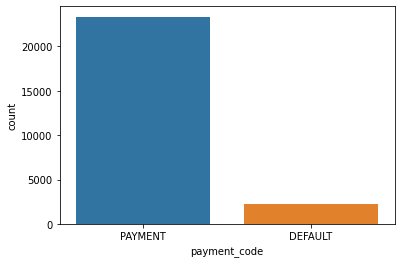

In [22]:
sns.countplot(x='payment_code', data=payment_data)
plt.show()

In [23]:
payment_data['payment_code'].value_counts(normalize = True)*100

PAYMENT    91.318127
DEFAULT     8.681873
Name: payment_code, dtype: float64

Of the total transactions, only 8.68% are defaulting

Lets check out the Clients

In [24]:
client_data.head()

client_id                 entity_type  entity_year_established
0        786  Australian Private Company                     2002
1        230  Australian Private Company                     2008
2        282      Individual/Sole Trader                     2001
3        447  Australian Private Company                     2013
4        310      Individual/Sole Trader                     2015

In [25]:
print(client_data.shape)
print(payment_data.shape)

(1287, 3)
(25559, 6)


In [26]:
print('unique client ids:', len(list(set(payment_data['client_id'].to_list()))))

unique client ids: 1281


There are 1287 clients in the client dataset but only 1281 are unique!

Identifying duplicated rows in client dataset based on client ID

In [27]:
client_data[client_data.duplicated(['client_id'], keep = False)]

client_id                     entity_type  entity_year_established
245         591      Australian Private Company                     2013
306         591      Australian Private Company                     2007
332         473      Australian Private Company                     2016
350         473          Individual/Sole Trader                     2008
401         165      Australian Private Company                     2015
816         591      Australian Private Company                     2015
1063        797  Discretionary Investment Trust                     2016
1115        165          Individual/Sole Trader                     2006
1172       1262      Australian Private Company                     2005
1182       1262      Australian Private Company                     2016
1275        797      Australian Private Company                     2002

It seems some clients are re-establishing themselves as either the same or different type of business entity type.

In [75]:
client_data2 = client_data.copy()

Since some clients re-establish themselves, we will keep their earliest establishment date and the latest entity_type

In [76]:
client_est_year = client_data[['client_id', 'entity_year_established']]
client_data.drop(['entity_year_established'], axis = 1, inplace = True)
client_data = client_data.drop_duplicates('client_id', keep = 'last')
client_est_year = client_est_year.sort_values('entity_year_established').drop_duplicates('client_id', keep = 'first')
client_data = pd.merge(client_data,client_est_year, on = 'client_id')
client_data.head()

client_id                 entity_type  entity_year_established
0        786  Australian Private Company                     2002
1        230  Australian Private Company                     2008
2        282      Individual/Sole Trader                     2001
3        447  Australian Private Company                     2013
4        310      Individual/Sole Trader                     2015

In [30]:
print('earliest year of transactions: ', min(payment_data['transaction_date'].dt.year))
print('latest year of transactions: ', max(payment_data['transaction_date'].dt.year))

earliest year of transactions:  2017
latest year of transactions:  2018


In [31]:
print('earliest transaction date: ', min(payment_data['transaction_date']))
print('latest transaction date: ', max(payment_data['transaction_date']))

earliest transaction date:  2017-07-02 18:08:02
latest transaction date:  2018-07-24 18:08:10


It seems the transactions are within one fiscal year

Creating new columns by splitting the 'transaction_date'

In [77]:
payment_data['transaction_year'] = payment_data['transaction_date'].dt.year
payment_data['transaction_month'] = payment_data['transaction_date'].dt.month
payment_data['transaction_day'] = payment_data['transaction_date'].dt.day
payment_data['date'] = payment_data['transaction_date'].dt.date

Re-arranging the payment data by sorting according to the transaction_date

In [78]:
payment_data = payment_data.sort_values('transaction_id').reset_index().drop(['index'], axis = 1)
payment_data.head()

transaction_id  contract_id  ...  transaction_day        date
0               1          585  ...                2  2017-07-02
1               2          585  ...                2  2017-07-02
2               3          586  ...                2  2017-07-02
3               4          586  ...                2  2017-07-02
4               5          587  ...                2  2017-07-02

[5 rows x 10 columns]

Investigating Client contracts

In [79]:
def client_contract_features(contract_id, client_id):

  client_sub = payment_data[(payment_data['contract_id'] == contract_id) & (payment_data['client_id'] == client_id)]
  client_sub = client_sub.sort_values(['date']).reset_index().drop(['index'], axis = 1)
  signing_date = min(client_sub['date'])

  client_sub.drop_duplicates(['date'], keep = 'first', inplace = True)
  #client_sub.head()
  unique_dates = client_sub['date'].tolist()
  unique_dates.remove(signing_date)
  #print(unique_dates)

  if len(unique_dates) > 1:
    time_diffs = [(unique_dates[i] - unique_dates[i-1]).days for i in range(1, len(unique_dates))]
    contract_length = (max(unique_dates) - signing_date).days
    #print(time_diffs)
  elif len(unique_dates) == 1:
    return [signing_date, (unique_dates[0] - signing_date).days, (unique_dates[0] - signing_date).days]
  elif len(unique_dates) == 0:
    return [signing_date, 999, 999]

  return [signing_date, int(mean(time_diffs)), contract_length]

In [80]:
client_contracts = payment_data[['contract_id', 'client_id']]
print(client_contracts.shape)
client_contracts.head()

(25559, 2)


contract_id  client_id
0          585        255
1          585        255
2          586        167
3          586        167
4          587        884

In [81]:
client_contracts.drop_duplicates(['contract_id', 'client_id'], keep = 'first', inplace = True)
print(client_contracts.shape)
client_contracts.head()

(1643, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


contract_id  client_id
0          585        255
2          586        167
4          587        884
6          588        623
8          589        365

In [82]:
client_contracts['contract_details'] = client_contracts.apply(lambda x: client_contract_features(x['contract_id'], x['client_id']), axis  = 1)
client_contracts.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


contract_id  client_id       contract_details
0          585        255  [2017-07-02, 30, 336]
2          586        167  [2017-07-02, 30, 336]
4          587        884  [2017-07-02, 30, 336]
6          588        623  [2017-07-02, 28, 316]
8          589        365  [2017-07-02, 27, 219]

In [83]:
client_contracts[['signing_date', 'avg_repayment_days', 'contract_length']] = pd.DataFrame(client_contracts['contract_details'].tolist(), index= client_contracts.index)
client_contracts.drop(['contract_details'], axis = 1, inplace = True)
client_contracts.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


contract_id  client_id signing_date  avg_repayment_days  contract_length
0          585        255   2017-07-02                  30              336
2          586        167   2017-07-02                  30              336
4          587        884   2017-07-02                  30              336
6          588        623   2017-07-02                  28              316
8          589        365   2017-07-02                  27              219

In [85]:
client_contracts['contract_length'].value_counts()

999    93
91     78
30     76
61     69
273    66
       ..
147     1
144     1
143     1
142     1
1       1
Name: contract_length, Length: 258, dtype: int64

In [87]:
payment_data_tr_split = payment_data.copy()

In [88]:
payment_data = pd.merge(payment_data, client_contracts, how = 'left', on = ['contract_id', 'client_id'])

In [89]:
payment_data.drop(['transaction_id', 'date'], axis = 1, inplace = True)

In [90]:
payment_data['client_id'].value_counts()

413     105
859      92
1124     81
777      79
1128     78
       ... 
936       2
712       2
780       2
134       1
387       1
Name: client_id, Length: 1281, dtype: int64

client - 413 has the highest number of transactions

When the data for the client with highest number of transactions is viewed, a pattern where defaults being quickly followed by payments, with the same transaction amount, on the same date and just seconds apart is seen.

Other defaults are followed by payments at a later date.

In [91]:
payment_data[payment_data['client_id'] == 413].head(20)

contract_id  client_id  ... avg_repayment_days  contract_length
6988           866        413  ...                  5              266
6989           866        413  ...                  5              266
7290           866        413  ...                  5              266
7291           866        413  ...                  5              266
8780           866        413  ...                  5              266
8781           866        413  ...                  5              266
10517          866        413  ...                  5              266
10518          866        413  ...                  5              266
10582          866        413  ...                  5              266
10583          866        413  ...                  5              266
11068          866        413  ...                  5              266
11069          866        413  ...                  5              266
11162          866        413  ...                  5              266
11163          866        413  ...                  5              266
11307          866        413  ...                  5              266
11308          866        413  ...                  5              266
11413          866        413  ...                  5              266
11414          866        413  ...                  5              266
11644          866        413  ...                  5              266
11645          866        413  ...                  5              266

[20 rows x 11 columns]

The Payments are to be made by a spcified due date as per contract. Once the due date and time is up, the transactions is classified as 'DEFAULT'.

This can happen even if the transaction is in process but not completed by the due time. In that case, a transaction would show as 'DEFAULT' and then be classified as 'PAYMENT' just seconds later.

It would be best to only keep such cases as their original classification and remove any duplicates. This is because, when we will try to configure a classifier that can identify such mis-classifications, we can make its job easier.

We now identify transactions which are duplicates in the collective aspet of 'client_id', 'transaction_year', transaction_month', trnascation_date' & 'payment_amt'

In [50]:
payment_data[payment_data.duplicated(['client_id', 'transaction_year', 'transaction_month', 'transaction_day', 'payment_amt'], keep=False)]

contract_id  client_id  ... avg_repayment_days  contract_length
292            408        808  ...                 11              280
293            408        808  ...                 11              280
294            408        808  ...                 11              280
295            408        808  ...                 11              280
374             72       1026  ...                  5               79
...            ...        ...  ...                ...              ...
25437         1604         44  ...                  4                7
25473         1602        456  ...                  4                7
25479         1070        534  ...                  6              167
25483          866        413  ...                  5              266
25555          866        413  ...                  5              266

[833 rows x 11 columns]

There are approx. 800 such transactions. We only keep their first instance as the dataframe is already sorted by 'transaction_date'.

In [92]:
payment_data.drop_duplicates(['client_id', 'transaction_year', 'transaction_month', 'transaction_day', 'payment_amt'], keep = 'first', inplace = True)

Merging both client and payment datasets now that an initial pre-processing has been completed

In [93]:
payment_data.shape

(25093, 11)

In [94]:
merged_data = pd.merge(payment_data, client_data, on = 'client_id')
print(merged_data.shape)

(25093, 13)


Dimensions after merging remain coherent

In [95]:
merged_data.head()

contract_id  client_id  ...                 entity_type  entity_year_established
0          585        255  ...  Australian Private Company                     2000
1          585        255  ...  Australian Private Company                     2000
2          585        255  ...  Australian Private Company                     2000
3          585        255  ...  Australian Private Company                     2000
4          585        255  ...  Australian Private Company                     2000

[5 rows x 13 columns]

In [96]:
print('no. of default transactions: ', merged_data[merged_data['payment_code'] == 'DEFAULT'].shape[0])

no. of default transactions:  2112


Determining client age based on year established and the time of transaction

In [97]:
merged_data['client_age'] = merged_data['transaction_year'] - merged_data['entity_year_established']
merged_data.drop(['transaction_year'], axis = 1, inplace = True)
merged_data.head()

contract_id  client_id  ... entity_year_established  client_age
0          585        255  ...                    2000          17
1          585        255  ...                    2000          17
2          585        255  ...                    2000          17
3          585        255  ...                    2000          17
4          585        255  ...                    2000          17

[5 rows x 13 columns]

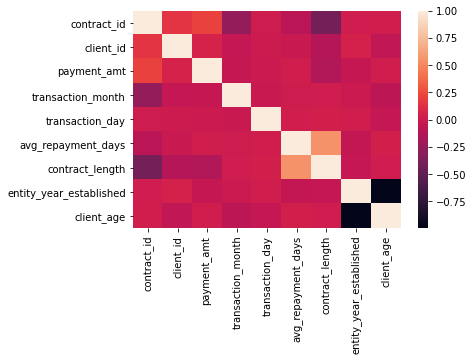

In [98]:
sns.heatmap(merged_data.corr())

#Entity_Type of clients

Getting an idea of the popular entity_type's

In [99]:
client_data['entity_type'].value_counts(normalize = True)*100

Australian Private Company        58.469945
Individual/Sole Trader            35.675254
Family Partnership                 3.044496
Discretionary Trading Trust        0.936768
Other Partnership                  0.780640
Australian Public Company          0.468384
Fixed Unit Trust                   0.312256
Discretionary Investment Trust     0.156128
Australian Proprietary Company     0.078064
Hybrid Trust                       0.078064
Name: entity_type, dtype: float64

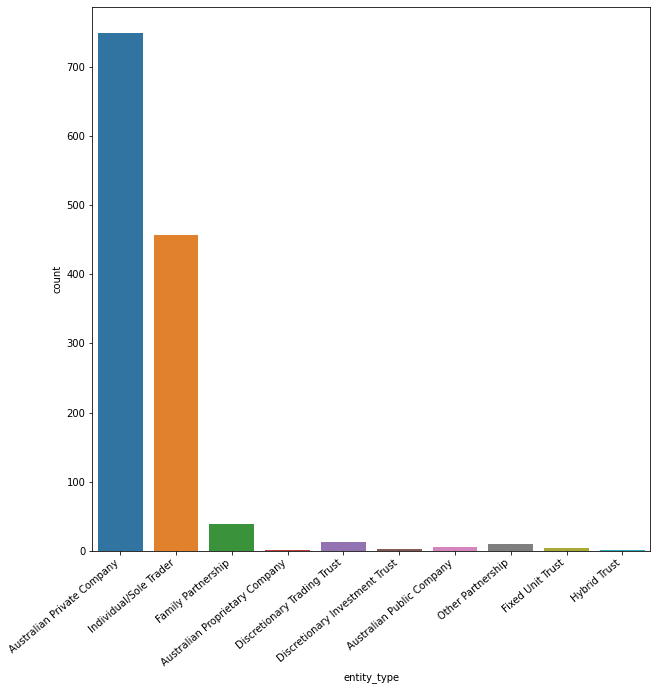

In [100]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x='entity_type', data = client_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Australian Private Company and Individual/Sole Traders are the largest share of entity_type's among clients

Within the Australian Private Company clients, there is a synonymous split in payment_code, i.e. 91% and 8% approx. respectively

In [101]:
merged_data[merged_data['entity_type'] == 'Australian Private Company']['payment_code'].value_counts(normalize = True)*100

PAYMENT    92.034061
DEFAULT     7.965939
Name: payment_code, dtype: float64

The distribution of Payment:Defaults for Australian Private Company mirrors the overall data.

In [102]:
merged_data.head()

contract_id  client_id  ... entity_year_established  client_age
0          585        255  ...                    2000          17
1          585        255  ...                    2000          17
2          585        255  ...                    2000          17
3          585        255  ...                    2000          17
4          585        255  ...                    2000          17

[5 rows x 13 columns]

We split the data by year and month and create a trend line to investigate the payment amounts.

In [103]:
merged_data['transaction_year'] = merged_data['transaction_date'].dt.year
merged_data['transaction_year'].value_counts()

2018    14807
2017    10286
Name: transaction_year, dtype: int64

Analysing the date by the timelines shown.

In [106]:
monthly_2017 = merged_data[merged_data['transaction_year'] == 2017].groupby(['transaction_month']).agg(func = sum)
monthly_2017 = monthly_2017[['payment_amt']]
monthly_2017.head()

payment_amt
transaction_month             
7                   1906113.54
8                   1395049.88
9                   1498174.21
10                  1466864.27
11                  1515271.66

In [107]:
monthly_2018 = merged_data[merged_data['transaction_year'] == 2018].groupby(['transaction_month']).agg(func = sum)
monthly_2018 = monthly_2018[['payment_amt']]
monthly_2018.head()

payment_amt
transaction_month             
1                   1762379.67
2                   1933514.54
3                   2182873.72
4                   2969831.95
5                   4075346.79

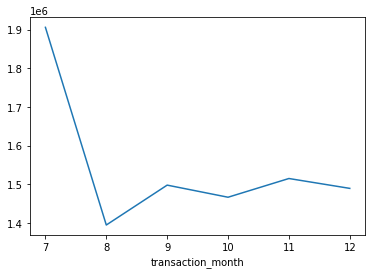

In [108]:
monthly_2017['payment_amt'].plot()

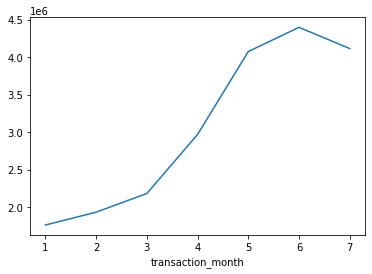

In [109]:
monthly_2018['payment_amt'].plot()

Given the financial year 2017-18, it is seen that the amount of payment has increased during the beginning and end of the financial year.

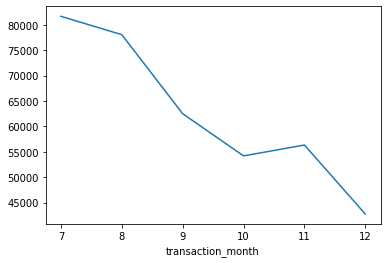

In [110]:
merged_data[(merged_data['transaction_year'] == 2017) & (merged_data['payment_code'] == 'DEFAULT')].groupby(['transaction_month']).agg(func = sum)['payment_amt'].plot()

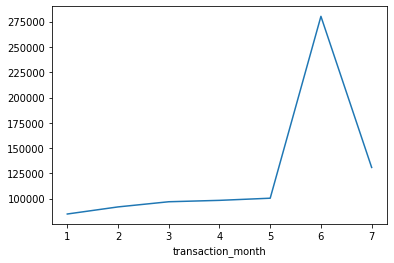

In [111]:
merged_data[(merged_data['transaction_year'] == 2018) & (merged_data['payment_code'] == 'DEFAULT')].groupby(['transaction_month']).agg(func = sum)['payment_amt'].plot()

Again, it can be seen that the payment amounts for Defaults were high during the start of the financial year and gradually decreased towards New Year's time. Subsequently, towards the second half of 2017-18, the payment amounts were significantly higher for defaults at the end.

In [112]:
merged_data[merged_data['payment_code'] == 'DEFAULT']['entity_type'].value_counts(normalize = True)*100

Australian Private Company        54.924242
Individual/Sole Trader            40.956439
Family Partnership                 1.562500
Discretionary Trading Trust        0.946970
Australian Public Company          0.757576
Discretionary Investment Trust     0.473485
Other Partnership                  0.284091
Hybrid Trust                       0.094697
Name: entity_type, dtype: float64

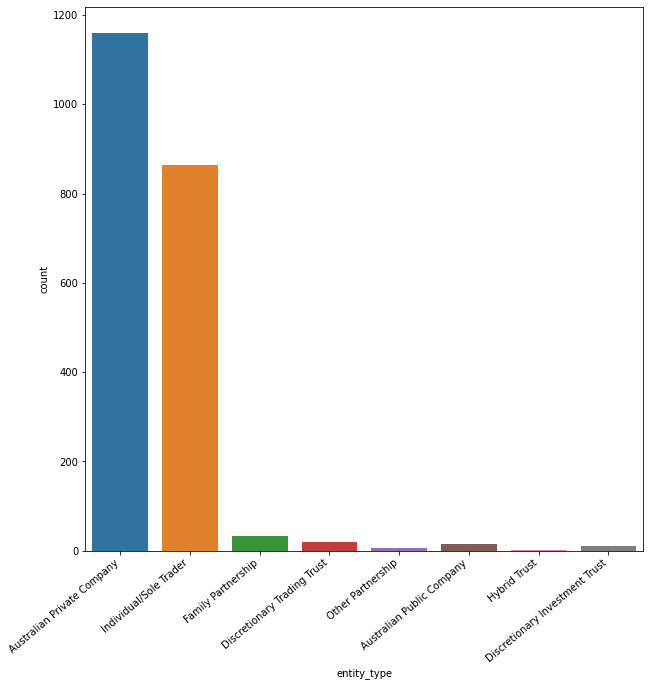

In [113]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x='entity_type', data=merged_data[merged_data['payment_code'] == 'DEFAULT'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Most defaulting organisation's were Australian Private companies and Individual/Sole Traders, a graphic, similar to the overall composition of business' in 2017-18

In [114]:
defaulting_client_by_year = merged_data[merged_data['payment_code'] == 'DEFAULT'][['client_id', 'entity_year_established', 'client_age']]
defaulting_client_by_year.shape

(2112, 3)

In [115]:
defaulting_client_by_year = defaulting_client_by_year.drop_duplicates('client_id', keep = 'first')
defaulting_client_by_year.shape

(354, 3)

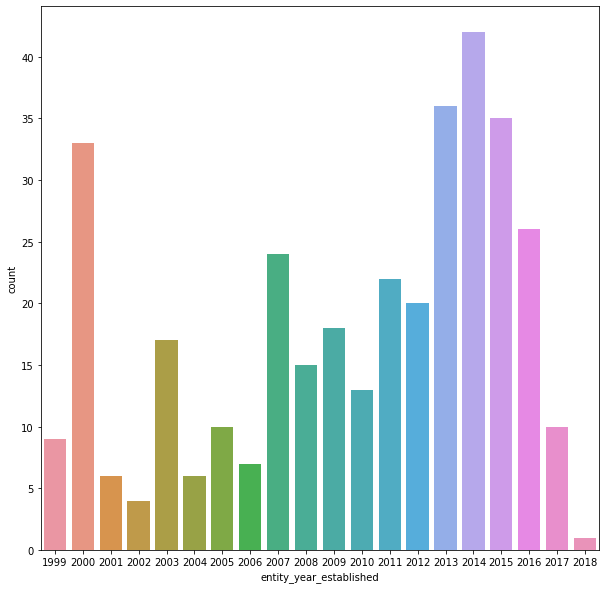

In [116]:
plt.figure(figsize=(10,10))
sns.countplot(x='entity_year_established', data=defaulting_client_by_year)
plt.show()

Most clients that defaulted were between 2011-16, and a significant portion comprised on clients established during the year 2000.

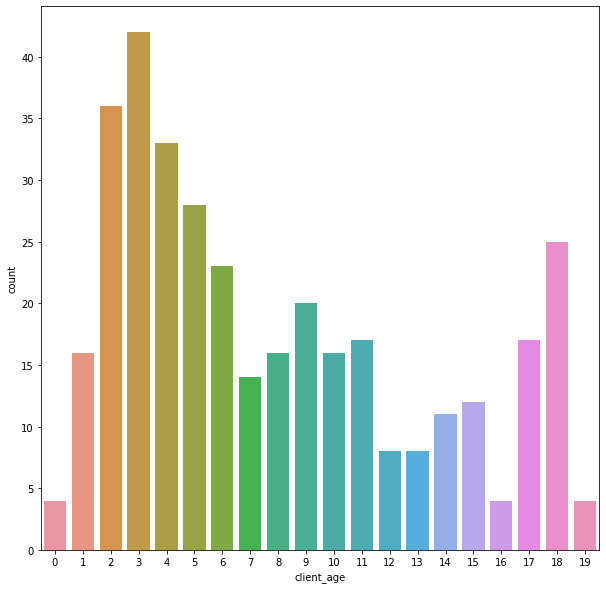

In [117]:
plt.figure(figsize=(10,10))
sns.countplot(x='client_age', data=defaulting_client_by_year)
plt.show()

The age of defualting clients can give a better idea.

We see that most defauting clients were young.

In [118]:
merged_data.head()

contract_id  client_id  ... client_age  transaction_year
0          585        255  ...         17              2017
1          585        255  ...         17              2017
2          585        255  ...         17              2017
3          585        255  ...         17              2017
4          585        255  ...         17              2017

[5 rows x 14 columns]

#Dissecting the transaction_date feature

In [119]:
#merged_data['transaction_month'] = merged_data['transaction_date'].apply(lambda x: calendar.month_name[x.month])
merged_data['transaction_day_of_week'] = merged_data['transaction_date'].apply(lambda x: calendar.day_name[x.weekday()])
merged_data['transaction_hour'] = merged_data['transaction_date'].dt.hour
merged_data.head()

contract_id  client_id  ... transaction_day_of_week  transaction_hour
0          585        255  ...                  Sunday                18
1          585        255  ...                  Sunday                18
2          585        255  ...               Wednesday                18
3          585        255  ...               Wednesday                18
4          585        255  ...               Wednesday                18

[5 rows x 16 columns]

In [120]:
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
merged_data['transaction_day_session'] = pd.cut(merged_data['transaction_hour'], bins=b, labels=l, include_lowest=True)

In [121]:
b = [1, 4, 7, 10, 12]
l = ['Quarter_3', 'Quarter_4','Quarter_1','Quarter_2']
merged_data['month'] = merged_data['transaction_date'].apply(lambda x: dt.datetime.strftime(x, '%b %Y'))
merged_data['transaction_quarter'] = pd.cut(merged_data['transaction_month'], bins=b, labels=l, include_lowest=True)
#merged_data.drop(['transaction_month'], axis = 1, inplace = True)

In [122]:
merged_data.head()

contract_id  client_id  ...     month  transaction_quarter
0          585        255  ...  Jul 2017            Quarter_4
1          585        255  ...  Jul 2017            Quarter_4
2          585        255  ...  Jul 2017            Quarter_4
3          585        255  ...  Jul 2017            Quarter_4
4          585        255  ...  Aug 2017            Quarter_1

[5 rows x 19 columns]

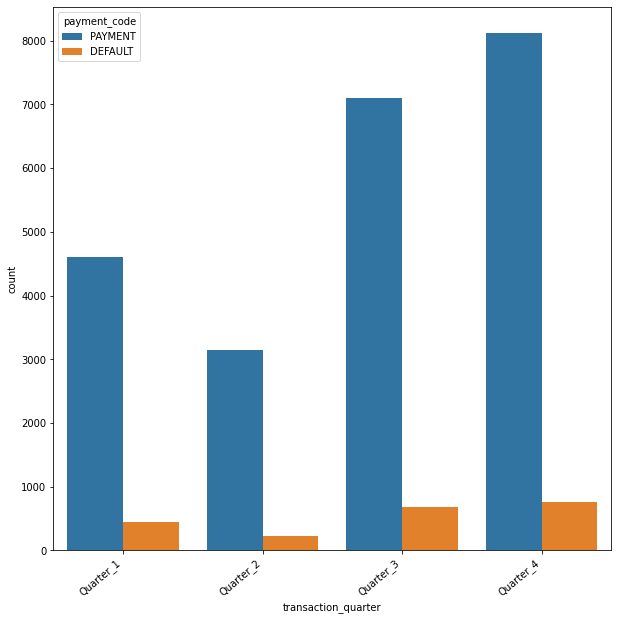

In [123]:
plt.figure(figsize = (10,10))
ax = sns.countplot(x = 'transaction_quarter', hue = 'payment_code', data = merged_data, order = ['Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

A visualization of the transaction statuses against their respective Quarters shows significant transactions are amde during Quarter 1 and 2 and concurrently a higher rate of defaults is also detected.

Quarters 3 & 4 have less no. of transactions and even less Defaults.

In [124]:
merged_data['transaction_day_session'].value_counts(normalize = True)*100

Eve              100.0
Night              0.0
Noon               0.0
Morning            0.0
Early Morning      0.0
Late Night         0.0
Name: transaction_day_session, dtype: float64

In [125]:
merged_data.drop(['transaction_day_session', 'transaction_hour'], axis = 1, inplace = True)

A breakdown of the time of transaction does not offer much info as all transactions are made during the Evening between 4 - 8 pm

In [126]:
merged_data.head()

contract_id  client_id  ...     month  transaction_quarter
0          585        255  ...  Jul 2017            Quarter_4
1          585        255  ...  Jul 2017            Quarter_4
2          585        255  ...  Jul 2017            Quarter_4
3          585        255  ...  Jul 2017            Quarter_4
4          585        255  ...  Aug 2017            Quarter_1

[5 rows x 17 columns]

In [127]:
print('unique contracts in dataset: ', len(list(set(merged_data['contract_id'].to_list()))))

unique contracts in dataset:  1641


In [128]:
print('unique IDs in transaction_dataset: ', len(list(set(merged_data['client_id'].to_list()))))

unique IDs in transaction_dataset:  1281


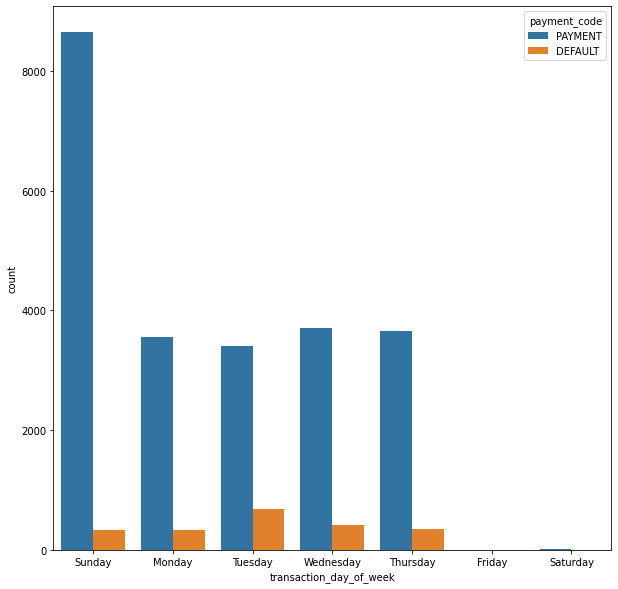

In [129]:
plt.figure(figsize = (10,10))
sns.countplot(x = 'transaction_day_of_week', hue = 'payment_code', data = merged_data, order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

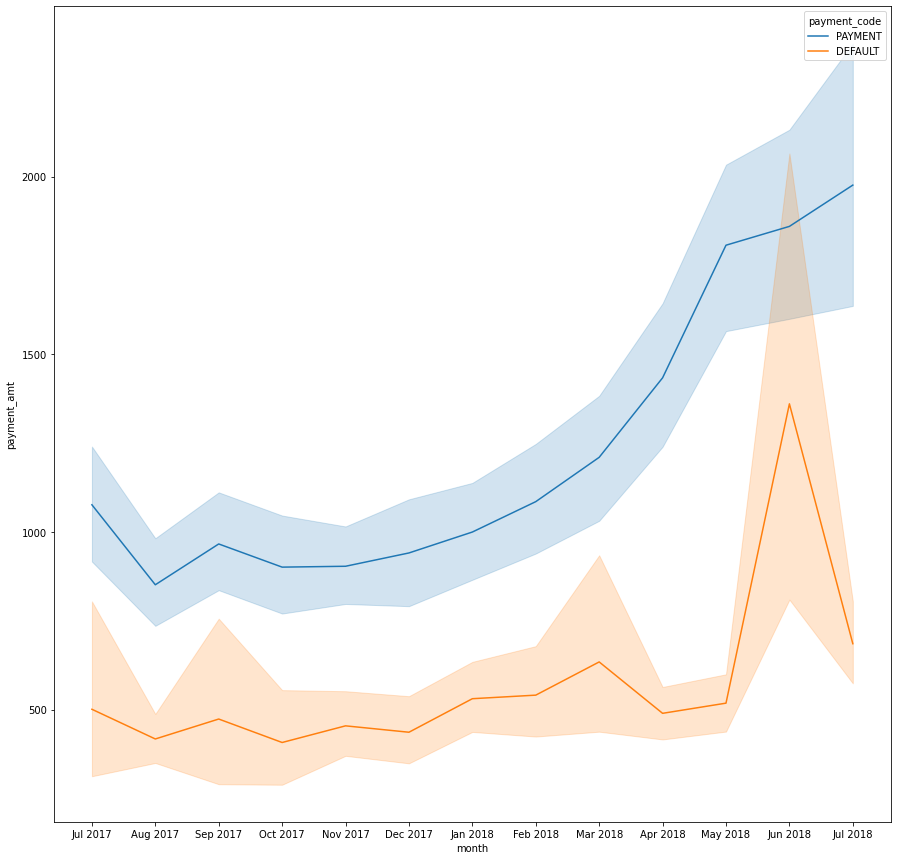

In [130]:
plt.figure(figsize = (15,15))
ax = sns.lineplot(x = 'month', y = 'payment_amt', hue = 'payment_code', data = merged_data)
plt.show()

In [131]:
merged_data.drop(['month'], axis = 1, inplace= True)

Another graph depicting how the transactions are split with respect to months in a year. The tranactions (default & payment) take a dip around New Year and pick up at the end of financial year.

In [132]:
merged_data.head()

contract_id  client_id  ... transaction_day_of_week  transaction_quarter
0          585        255  ...                  Sunday            Quarter_4
1          585        255  ...                  Sunday            Quarter_4
2          585        255  ...               Wednesday            Quarter_4
3          585        255  ...               Wednesday            Quarter_4
4          585        255  ...               Wednesday            Quarter_1

[5 rows x 16 columns]

In [133]:
merged_data[merged_data['payment_code'] == 'DEFAULT']['client_id'].value_counts()

413     30
859     28
231     26
995     25
718     25
        ..
687      1
757      1
813      1
224      1
1247     1
Name: client_id, Length: 354, dtype: int64

In [134]:
merged_data.head()

contract_id  client_id  ... transaction_day_of_week  transaction_quarter
0          585        255  ...                  Sunday            Quarter_4
1          585        255  ...                  Sunday            Quarter_4
2          585        255  ...               Wednesday            Quarter_4
3          585        255  ...               Wednesday            Quarter_4
4          585        255  ...               Wednesday            Quarter_1

[5 rows x 16 columns]

In [135]:
merged_data['signing_date'] = pd.to_datetime(merged_data['signing_date'])
merged_data['signing_month'] = merged_data['signing_date'].dt.month

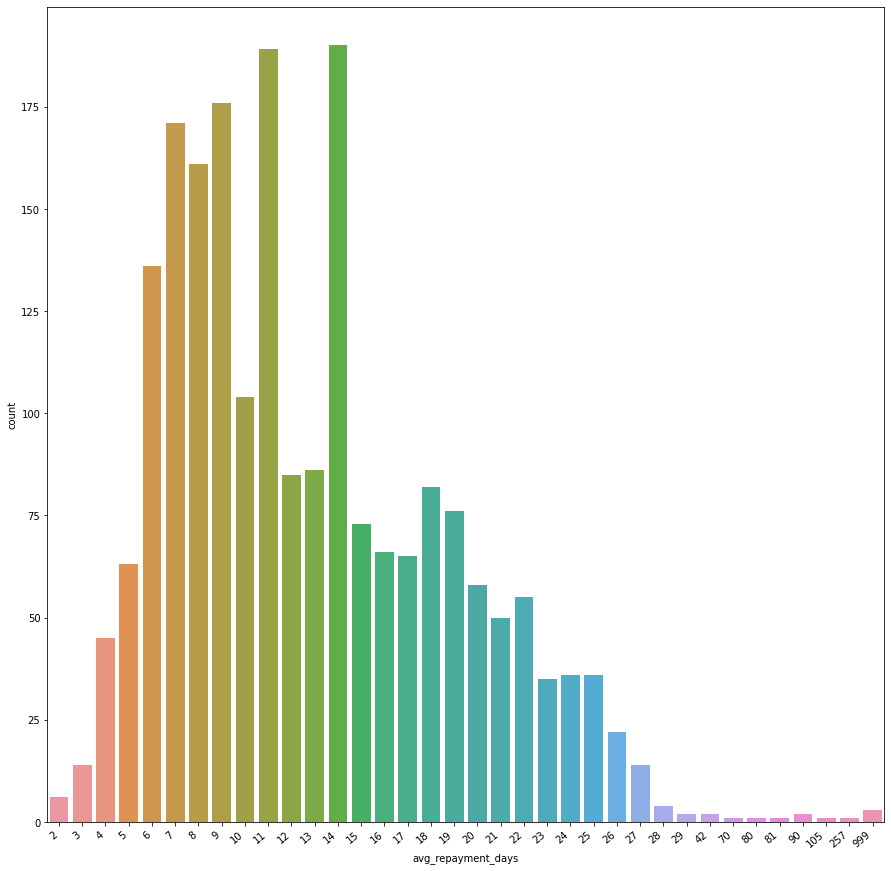

In [136]:
plt.figure(figsize = (15,15))
ax = sns.countplot(x = 'avg_repayment_days', data = merged_data[merged_data['payment_code'] == 'DEFAULT'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

This graph shows that clients that sign a contract, where they have to repay anywhere between 4 to 22 days are most likely to default. Client within this range have Defaulted between 50 to 175+ times in one year.

This can also be attributed to the fact that clients with frequent payment deadlines are more prone to defaulting than those who pay over a significant period of time.

In [141]:
data2 = merged_data[['transaction_date', 'entity_type', 'client_age', 'payment_amt', 'payment_code']]
print(data2.shape)
data2.head()

(25093, 5)


transaction_date                 entity_type  ...  payment_amt  payment_code
0 2017-07-02 18:08:02  Australian Private Company  ...     25049.96       PAYMENT
1 2017-07-02 18:08:02  Australian Private Company  ...        50.00       PAYMENT
2 2017-07-05 18:08:09  Australian Private Company  ...      2133.33       PAYMENT
3 2017-07-05 18:08:09  Australian Private Company  ...       312.49       PAYMENT
4 2017-08-02 18:08:48  Australian Private Company  ...      2083.33       PAYMENT

[5 rows x 5 columns]

In [142]:
data2['transaction_month'] = data2['transaction_date'].dt.month
data2['transaction_day'] = data2['transaction_date'].dt.day
data2['transaction_hour'] = data2['transaction_date'].dt.hour
data2['transaction_minute'] = data2['transaction_date'].dt.minute
data2['transaction_second'] = data2['transaction_date'].dt.second
data2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

transaction_date  ... transaction_second
0 2017-07-02 18:08:02  ...                  2
1 2017-07-02 18:08:02  ...                  2
2 2017-07-05 18:08:09  ...                  9
3 2017-07-05 18:08:09  ...                  9
4 2017-08-02 18:08:48  ...                 48

[5 rows x 10 columns]

In [143]:
data2['transaction_minute'].value_counts()

8    21166
9     3927
Name: transaction_minute, dtype: int64

In [144]:
data2[data2['payment_code'] == 'DEFAULT'].shape

(2112, 10)

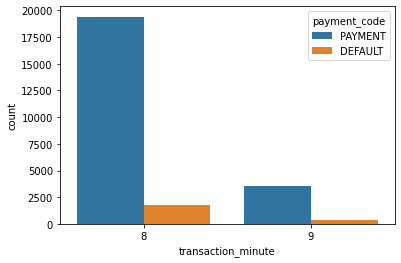

In [145]:
sns.countplot(x='transaction_minute', hue = 'payment_code', data = data2)
plt.show()

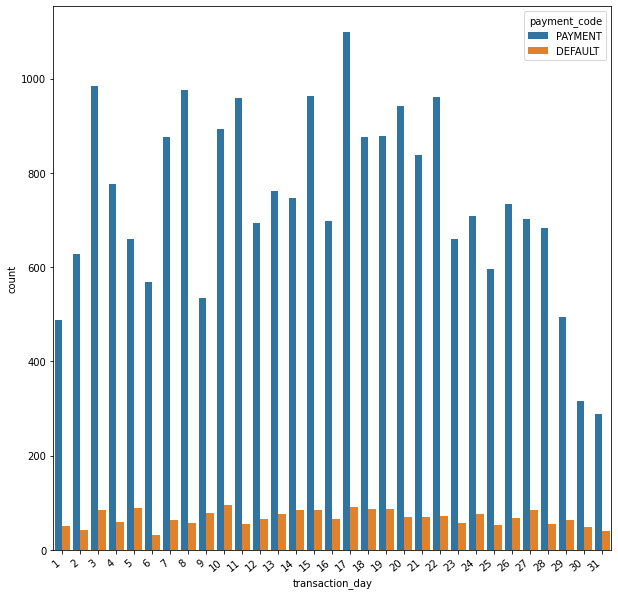

In [146]:
plt.figure(figsize = (10,10))
ax = sns.countplot(x = 'transaction_day', hue = 'payment_code', data = data2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [147]:
data2.isna().sum()

transaction_date      0
entity_type           0
client_age            0
payment_amt           0
payment_code          0
transaction_month     0
transaction_day       0
transaction_hour      0
transaction_minute    0
transaction_second    0
dtype: int64

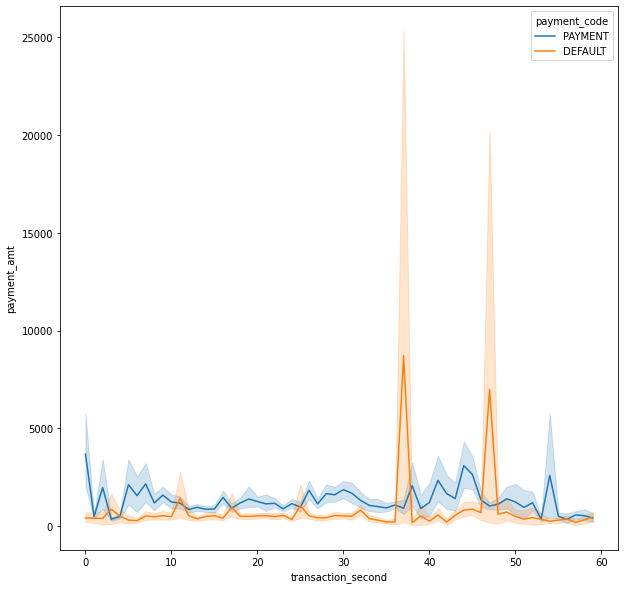

In [148]:
plt.figure(figsize = (10,10))
sns.lineplot(x = 'transaction_second', y = 'payment_amt', hue='payment_code', data = data2)
plt.show()

#Modelling

In [149]:
data2.head()

transaction_date  ... transaction_second
0 2017-07-02 18:08:02  ...                  2
1 2017-07-02 18:08:02  ...                  2
2 2017-07-05 18:08:09  ...                  9
3 2017-07-05 18:08:09  ...                  9
4 2017-08-02 18:08:48  ...                 48

[5 rows x 10 columns]

Preparing data for modelling.

In [150]:
target_label_encoder = LabelEncoder()
et_le = LabelEncoder()
X = data2[['entity_type', 'client_age', 'payment_amt', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_minute', 'transaction_second']]
y = data2['payment_code']

Splitting the dataset by a 80:20 split.

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = 0.2, stratify = y)
# X_train, X_val, y_train, y_val = train_test_split(trainX_1, trainy_1, random_state = 1, test_size = 0.25, stratify = trainy_1)
print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(20074, 8) (20074,)
(5019, 8) (5019,)


Label encoding features.

In [152]:
y_train = target_label_encoder.fit_transform(y_train)
y_test = target_label_encoder.transform(y_test)

In [153]:
X_train['entity_type_N'] = et_le.fit_transform(X_train['entity_type'])
X_train.drop(['entity_type'], axis = 1, inplace=True)
X_test['entity_type_N'] = et_le.transform(X_test['entity_type'])
X_test.drop(['entity_type'], axis = 1, inplace=True)
X_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

client_age  payment_amt  ...  transaction_second  entity_type_N
6048           17       249.99  ...                  38              0
21332           2       106.66  ...                  28              0
23472           6       833.33  ...                   8              0
14575           6       583.33  ...                  33              0
7796           15       583.33  ...                  14              0

[5 rows x 8 columns]

The PR-AUC curve as Metric for evaluation.

This curve examines the classifiers capability to correctly classify the Minority Class, especially when the data is highly imbalanced.

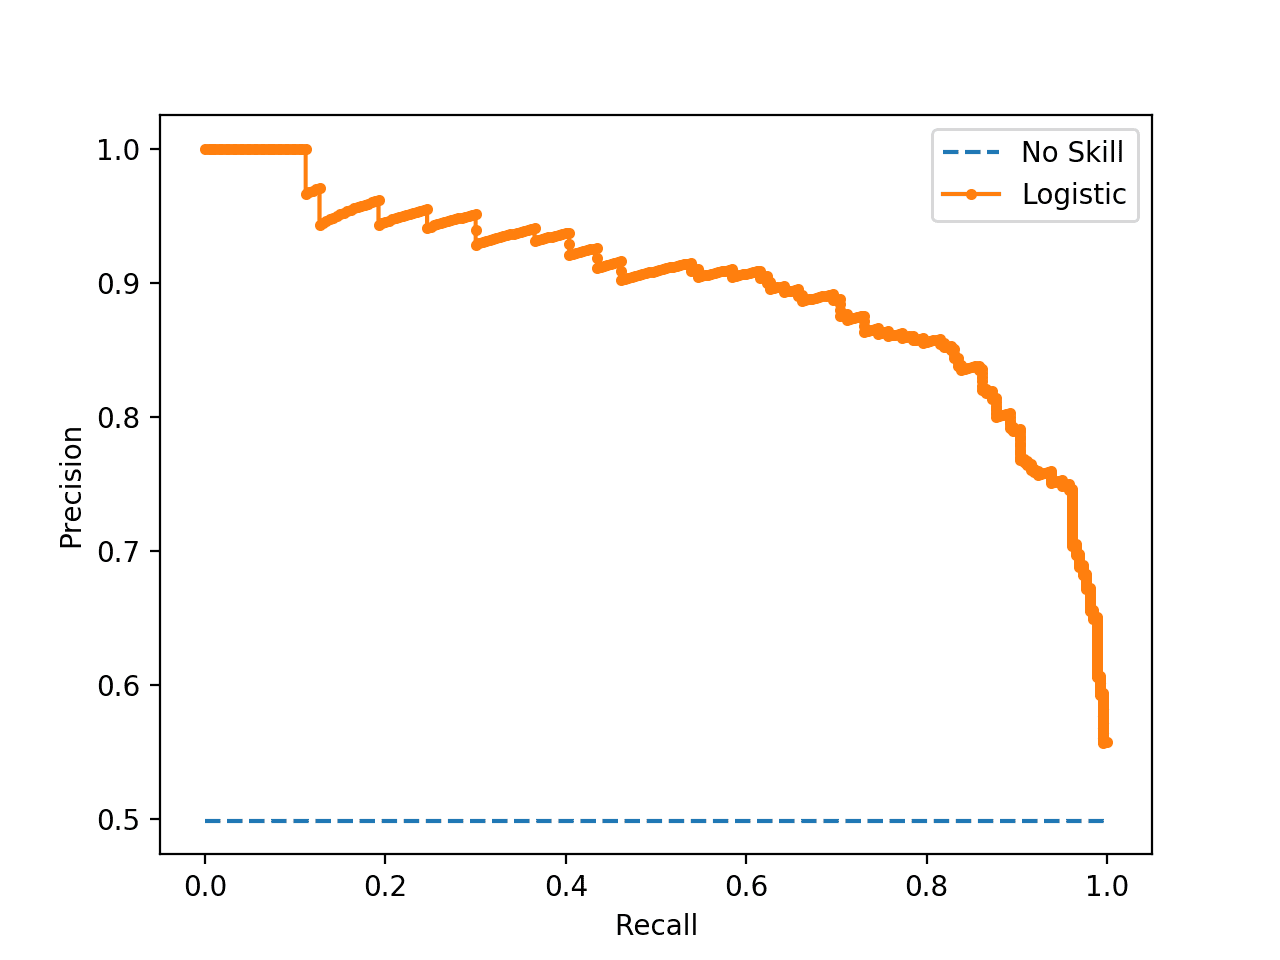

Applying Logistic Regression Model to data with balanced class weights. This will make sure the algorithm penalizes the model based on distribution of target classes.

A grid search is used to test several parameter values and the scoring is dependent on 'average_precision' or PR-AUC.

A 5-fold cross validation is carried out.

In [154]:
parameters = {'penalty':['l1', 'l2'], 'class_weight': ['balanced'], 'random_state': [1], 'solver': ['liblinear', 'lbfgs']}
logr_grid_model = GridSearchCV(LogisticRegression(), param_grid = parameters, scoring='average_precision', n_jobs = -1, cv = 5, verbose = 2)
logr_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'random_state': [1],
                         'solver': ['liblinear', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='average_precision', verbose=2)

In [155]:
pd.DataFrame(logr_grid_model.cv_results_)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       3.360033      0.992059  ...        0.001388                1
1       0.002461      0.000138  ...             NaN                4
2       0.139244      0.015653  ...        0.001737                2
3       0.284640      0.072973  ...        0.001614                3

[4 rows x 17 columns]

In [156]:
print('best logistic regression model parameters:', logr_grid_model.best_estimator_)
print('best model pr_auc score on validation:', logr_grid_model.best_score_)

best logistic regression model parameters: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best model pr_auc score on validation: 0.9395272763232085


The model with the best result uses 'l1' penalty & 'liblinear' solver.

In [157]:
print('model performance on test set (pr_auc):', logr_grid_model.score(X_test, y_test))

model performance on test set (pr_auc): 0.9397487961305366


The Logistic Regression model achieved a best score of 0.94.

In [158]:
filename = 'logistic_regression_classifier.sav'
pickle.dump(logr_grid_model, open(filename, 'wb'))

In [159]:
print(classification_report(y_test, logr_grid_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.10      0.59      0.17       422
           1       0.93      0.51      0.66      4597

    accuracy                           0.52      5019
   macro avg       0.52      0.55      0.42      5019
weighted avg       0.86      0.52      0.62      5019



In [160]:
print(confusion_matrix(y_test, logr_grid_model.predict(X_test)))

[[ 251  171]
 [2251 2346]]


<function matplotlib.pyplot.show>

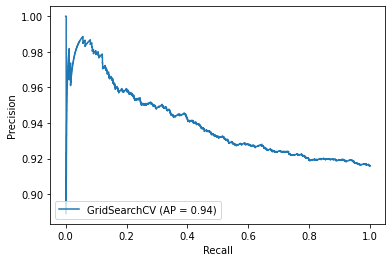

In [161]:
plot_precision_recall_curve(logr_grid_model, X_test, y_test)
plt.show

Applying Decision Tree Model to data with balanced class weights.

A grid search is used to test several parameter values and the scoring is dependent on 'average_precision' or PR-AUC.

A 5-fold cross validation is carried out.

In [162]:
parameters = {'max_depth':[3, 5, 8], 'max_features': ['sqrt', 'log2', 'None'], 'random_state': [1], 'class_weight': ['balanced']}
dt_grid_model = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters, scoring='average_precision', n_jobs = -1, cv = 5, verbose = 2)
dt_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [3, 5, 8],
 

In [163]:
pd.DataFrame(dt_grid_model.cv_results_)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.018130      0.002609  ...        0.002452                6
1       0.020272      0.003079  ...        0.003324                5
2       0.014816      0.003872  ...             NaN                7
3       0.021598      0.002904  ...        0.003480                4
4       0.026205      0.005292  ...        0.003159                3
5       0.012139      0.000962  ...             NaN                8
6       0.025587      0.003133  ...        0.002825                2
7       0.028721      0.002293  ...        0.003522                1
8       0.012292      0.002662  ...             NaN                9

[9 rows x 17 columns]

In [164]:
print('best DT parameters:', dt_grid_model.best_params_)
print('best DT score (pr_auc):', dt_grid_model.best_score_)

best DT parameters: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'log2', 'random_state': 1}
best DT score (pr_auc): 0.9501994885657442


Best performing model has max_depth of 8 & max_features set to 'log2'

In [165]:
print('best DT model performance on test set (pr_auc):', dt_grid_model.score(X_test, y_test))

best DT model performance on test set (pr_auc): 0.9515822937570177


On the test set, the model achieved 0.95, which is slightly better than Logistic Regression.

In [166]:
print(classification_report(y_test, dt_grid_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.11      0.73      0.20       422
           1       0.95      0.48      0.64      4597

    accuracy                           0.50      5019
   macro avg       0.53      0.61      0.42      5019
weighted avg       0.88      0.50      0.60      5019



In [167]:
print(confusion_matrix(y_test, dt_grid_model.predict(X_test)))

[[ 308  114]
 [2376 2221]]


<function matplotlib.pyplot.show>

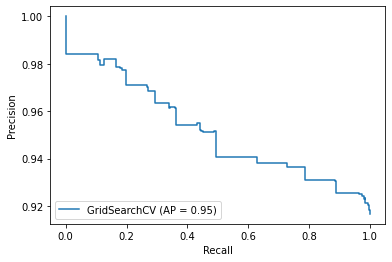

In [168]:
plot_precision_recall_curve(dt_grid_model, X_test, y_test)
plt.show

In [169]:
filename = 'Decision_Tree_classifier.sav'
pickle.dump(dt_grid_model, open(filename, 'wb'))

Applying XGBClassifier Model to data with balanced class weights. 

A grid search is used to test several parameter values and the scoring is dependent on 'average_precision' or PR-AUC.

A 5-fold cross validation is carried out.

In [170]:
counter = Counter(y_train)
# estimating scale_pos_weight value, since the class labels are 0 and 1.
weight = counter[0] / counter[1]
parameters = {'n_estimators':[3, 5, 8], 'max_depth':[3, 5, 8], 'learning_rate': [0.001, 0.01, 0.1], 'use_label_encoder': [False], 'random_state': [1], 'scale_pos_weight': [weight]}
xgbc_grid_model = GridSearchCV(XGBClassifier(), param_grid = parameters, scoring='average_precision', n_jobs = -1, cv = 5, verbose = 2)
xgbc_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    9.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 8], 'n_estimators': [3, 5, 8],
                         'random_state': [1],
 

In [171]:
pd.DataFrame(xgbc_grid_model.cv_results_)

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.124016      0.075276  ...        0.002246               25
1        0.084924      0.006648  ...        0.002246               25
2        0.120953      0.009890  ...        0.002246               25
3        0.077153      0.004978  ...        0.002101               19
4        0.113551      0.010688  ...        0.002101               19
5        0.160779      0.006061  ...        0.002101               18
6        0.107606      0.002605  ...        0.003872               11
7        0.167940      0.008559  ...        0.003804               10
8        0.238539      0.007804  ...        0.003725                9
9        0.060996      0.002377  ...        0.000929               24
10       0.086143      0.010211  ...        0.000867               23
11       0.107962      0.004292  ...        0.002729               22
12       0.075836      0.003397  ...        0.002441               17
13       0.105027      0.003148  ...        0.002403               16
14       0.162230      0.016889  ...        0.004515               13
15       0.107448      0.004498  ...        0.003761                7
16       0.158879      0.005266  ...        0.003120                6
17       0.234419      0.006795  ...        0.004390                4
18       0.059125      0.002207  ...        0.001920               21
19       0.080568      0.005138  ...        0.001766               15
20       0.105734      0.002255  ...        0.001511               14
21       0.073428      0.000637  ...        0.004144               12
22       0.104282      0.003577  ...        0.003292                8
23       0.149980      0.006506  ...        0.003623                5
24       0.106439      0.004848  ...        0.002736                3
25       0.161653      0.009124  ...        0.001938                2
26       0.230955      0.013013  ...        0.002094                1

[27 rows x 19 columns]

In [172]:
print('best XGBClassifier parameters:', xgbc_grid_model.best_params_)
print('best XGBClassifier score (pr_auc):', xgbc_grid_model.best_score_)

best XGBClassifier parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 8, 'random_state': 1, 'scale_pos_weight': 0.0919277632724108, 'use_label_encoder': False}
best XGBClassifier score (pr_auc): 0.9630148492462279


The best performing model had a max_depth of 8, 8 estimators / trees and balanced weighting of 0.0917, which is the penalizing weight applied to misclassified data.

In [173]:
print('best XGBClassifier model performance on test set (pr_auc):', xgbc_grid_model.score(X_test, y_test))

best XGBClassifier model performance on test set (pr_auc): 0.965418648155432


The model achieved 0.96 on test data, which is slightly better than the DecisionTree model

In [174]:
filename = 'XGBoost_classifier.sav'
pickle.dump(xgbc_grid_model, open(filename, 'wb'))

In [175]:
print(classification_report(y_test, xgbc_grid_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.16      0.72      0.26       422
           1       0.96      0.65      0.78      4597

    accuracy                           0.66      5019
   macro avg       0.56      0.68      0.52      5019
weighted avg       0.89      0.66      0.73      5019



In [176]:
print(confusion_matrix(y_test, xgbc_grid_model.predict(X_test)))

[[ 302  120]
 [1604 2993]]


<function matplotlib.pyplot.show>

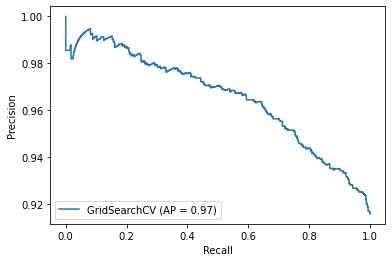

In [177]:
plot_precision_recall_curve(xgbc_grid_model, X_test, y_test)
plt.show

#Conclusion

From the dataset we can see that most of the transactions were defaulted by clients that were young (1 - 5 years) and were classified as Australian Private Company.

The data being highly imbalanced, methods such as Precision-Recall curve give a very good basis to train a model on that can identify these defaulting clients.

Suggestions:


*   Random Oversampling - this method will reduce the imbalance, generating data for the minority class, using samples from the existing minority data.
*   Collect Additional data on Customers - this will give better insight into the client and help the model become more robust.


*   Other Robust Classifiers - for e.g. KNearestNeighbor, Adaboost.



